In [26]:
%load_ext autoreload
%autoreload 2
%pip install -U albumentations

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Requirement already up-to-date: albumentations in /usr/local/lib/python3.6/dist-packages (0.4.6)


In [27]:
%rm -rf '/content/TSAI-EVA5/'
!git clone --branch ram https://github.com/Anjan-AI/TSAI-EVA5.git
import sys
sys.path.append('/content/TSAI-EVA5/S12/')

Cloning into 'TSAI-EVA5'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (298/298), done.
remote: Compressing objects: 100% (242/242), done.
remote: Total 905 (delta 117), reused 218 (delta 48), pack-reused 607
Receiving objects: 100% (905/905), 47.47 MiB | 36.63 MiB/s, done.
Resolving deltas: 100% (372/372), done.


In [28]:
from Dataset.dataset import GetTinyImageNet
import torch
import os
import torchvision
import torchvision.transforms as transfroms
from Dataset.image_augmentations import AlbumentationTransforms
from Utils.SetCuda import set_seed,initialize_cuda
from Utils.utilities import print_model_summary,cross_entropy_loss
from Utils.evaluate import show_misclassified_images,evaluate_classwise_accuracy
from Utils.GradCam import GradCamView
from Utils.show_image import show_train_data_imagenet
from models.resnet import ResNet18
from Training.Training_Testing import train ,test,runmodel
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
%matplotlib inline

In [29]:
train_transform = AlbumentationTransforms(augmentation = True, mean=(0.4914, 0.4822, 0.4465) ,std_dev =(0.2471, 0.2435, 0.2616),
                                          horizontal_flip_prob=0.6,vertical_flip_prob=0.6,rotate_degree =30.0,cutout= True)
test_transform = AlbumentationTransforms(augmentation = True, mean=(0.4914, 0.4822, 0.4465) ,std_dev =(0.2471, 0.2435, 0.2616))

In [30]:
Data = GetTinyImageNet(train_transform, test_transform, split=0.7)

TinyImageNet Downloaded
Found 200 classes


In [31]:
train_set = Data.get_dataset(train = True)
test_set = Data.get_dataset(train = False)
classes = Data.classes

In [32]:
len(train_set), len(test_set), len(classes)

(77000, 33000, 200)

In [33]:
#check for the GUP avaliblbity and manual seeding
seed =1
cuda,device = initialize_cuda(seed)
# Load the test and train data , set the batch size & Num_workeres.
train_loader = Data.data_loader(train_set,cuda= cuda ,batch_size = 64 , num_workers = 4 )
test_loader = Data.data_loader(test_set,cuda= cuda ,batch_size = 64 , num_workers = 4 )

GPU Available? False


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


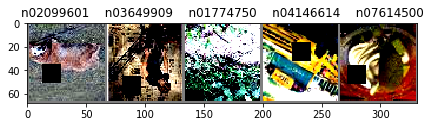

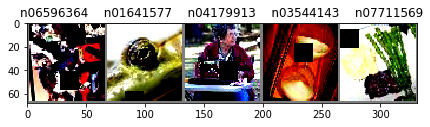

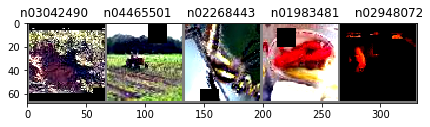

In [34]:
show_train_data_imagenet(train_loader, classes,3)

In [35]:
# laod the model and print the summary
model = ResNet18(num_classes=200)
type(model)
print_model_summary(model, input_size = (3,64,64), device=device)

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 